__Kaggle competition - Titanic survivorship__

1. [Import](#Import)
    1. [Tools](#Tools)
    1. [Data](#Data)    
1. [EDA](#EDA)
    1. [Category feature EDA](#category-feature-EDA)
    1. [Number feature EDA](#number-feature-EDA)
    1. [Faceting](#Faceting)
    1. [Target variable evaluation](#Target-variable-evaluation)    
1. [Data preparation](#Data-preparation)
    1. [Missing data](#Missing-data)
    1. [Feature engineering](#Feature-engineering)
        1. [Handcrafted](#Handcrafted)
        1. [Polynomial features](#Polynomial-features)
        1. [Encoding](#Encoding)
    1. [Feature transformation](#Feature-transformation)
        1. [Skew correction](#Skew-correction)
        1. [Scaling](#Scaling)     
    1. [Outliers](#Outliers)
1. [Feature importance](#Feature-importance)    
1. [Modeling](#Modeling)
    1. [Data preparation](#Data-preparation-1)
    1. [Bayesian hyper-parameter optimization](#Bayesian-hyper-parameter-optimization)
    1. [Model performance evaluation - standard models](#Model-performance-evaluation-standard-models)
    1. [Model explanability](#Model-explanability)
    1. [Submission - standard models](#Submission-standard-models)
1. [Stacking](#Stacking)
    1. [Primary models](#Primary-models)
    1. [Meta model](#Meta-model)                
    1. [Model performance evaluation - stacked models](#Model-performance-evaluation-stacked-models)
    1. [Submission - stacked models](#Submission-stacked-models)    

# Import

<a id = 'Import'></a>

## Tools

<a id = 'Tools'></a>

In [1]:
# standard libary and settings
import copy
import os
import sys
import importlib
import itertools
from functools import reduce
import time; rundate = time.strftime("%Y%m%d")

import warnings
warnings.simplefilter("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np
np.set_printoptions(threshold=np.inf, suppress=True)

import pandas as pd
pd.set_option("display.max_rows", 500); pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.datasets as datasets
import sklearn.ensemble as ensemble
import sklearn.impute as impute
import sklearn.linear_model as linear_model
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import category_encoders as ce

import lightgbm
import xgboost

from hyperopt import hp

import eif
import shap
shap.initjs()

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import squarify

%matplotlib inline

try:
    #     import mlmachine as mlm
    #     from prettierplot.plotter import PrettierPlot
    #     import prettierplot.style as style
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    import mlmachine.data as data
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PandasPipeline,
        KFoldTargetEncoder,
        ContextImputer,
        PandasFeatureUnion,
        DualTransformer,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style
else:
    print(
        "This notebook relies on the libraries mlmachine and prettierplot. Please run:"
    )
    print("\tpip install mlmachine")
    print("\tpip install prettierplot")

## Data

<a id = 'Data'></a>

In [2]:
# load data and print dimensions
df_train, df_valid = data.titanic()

print("Training data dimensions: {}".format(df_train.shape))
print("Validation data dimensions: {}".format(df_valid.shape))

Training data dimensions: (891, 12)
Validation data dimensions: (418, 11)


In [3]:
# display info and first 5 rows
df_train.info()
display(df_train[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.283300,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,NaN,S


In [4]:
# review counts of different column types
df_train.dtypes.value_counts()

object     5
int64      5
float64    2
dtype: int64

In [5]:
# Load training data into mlmachine
train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId", "Ticket"],
    identify_as_category=["Cabin","Embarked","Name","Pclass"],
    identify_as_count=["Parch","SibSp"],
    target_type="category",
)

******************
category label encoding

0 __> 0
1 __> 1


In [6]:
train.feature_by_type

{'bool': [],
 'category': ['Cabin', 'Embarked', 'Name', 'Pclass', 'Sex'],
 'continuous': ['Age', 'Fare'],
 'count': ['Parch', 'SibSp'],
 'date': []}

In [7]:
# load training data into mlmachine
valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId", "Ticket"],
    identify_as_category=["Cabin","Embarked","Name","Pclass"],
    identify_as_count=["Parch","SibSp"],    
)

#### notes


General
- if feature starts as number, future representations are going to be a number

bool
- how to identify
    - if values are only 1's and 0's
        - this will include columns that are one hot encoded
- visuals
    - general
        - side by side bar, overall counts
    - categorical target
        - stacked bar
            - proportion of 1's and 0's within class 0, within class 1, within, class n
    - continuous target
        - 
- dtype = float64 or bool

ordinal
- how to identify
    - includes the str "_Encoded", which will be applied by PandasPipeline
        - Dont let these become boolean if there are only two
- visuals
    - general
        - side by side bar, overall counts
    - categorical target
        - 
    - continuous target
        - 

- dtype = object

nominal
- how to identify
    - rule 1
- visuals
    - general
        - 
    - categorical target
        - 
    - continuous target
        - 
- dtype = object

continuous    
- how to identify
    - rule 1
- visuals
    - general
        - 
    - categorical target
        - 
    - continuous target
        - 

- dtype = float64

counts
- how to identify
    - rule 1
- visuals
    - general
        - 
    - categorical target
        - 
    - continuous target
        - 
- dtype = float64bool

    

nominal
- starts with a known column name (can this be tightened?) and ends with a known value



It's worse than you think, even if you think it's worse than you think.

@Stephan Kolassa's answer already makes one key point. Small integers could mean counts rather than categories: 3, meaning 3 cars or cats, is not the same as 3, meaning "person owns a car" or "person is owned by a cat".

Decimal points could lurk within object variables, as part of coded classifications, e.g. of industries or diseases.

Measurements strict sense could just be integers by convention, e.g. heights of people may just be reported as integer cm or inches, blood pressures as integer mm Hg.

The number of distinct (a better term than "unique", which still has the primary meaning of occurring just once) values is not a good guide either. The number of different heights of people possible in moderate samples is probably much less than the number of different religious affiliations or ethnic origins.

# EDA

<a id = 'EDA'></a>

## Category feature EDA

<a id = 'category-feature-EDA'></a>

Feature summary Feature vs. target summary Target proportion 
 
 
 Embarked 
 count 
 proportion 
 
 
 
 
 S 
 644 
 72.440945 
 
 
 C 
 168 
 18.897638 
 
 
 Q 
 77 
 8.661417 
 
 
 
 
 
 Embarked 
 0 
 1 
 
 
 
 
 C 
 75 
 93 
 
 
 Q 
 47 
 30 
 
 
 S 
 427 
 217 
 
 
 
 
 
 Class 
 C 
 Q 
 S 
 
 
 
 
 Died 
 44.642857 
 61.038961 
 66.304348 
 
 
 Survived 
 55.357143 
 38.961039 
 33.695652

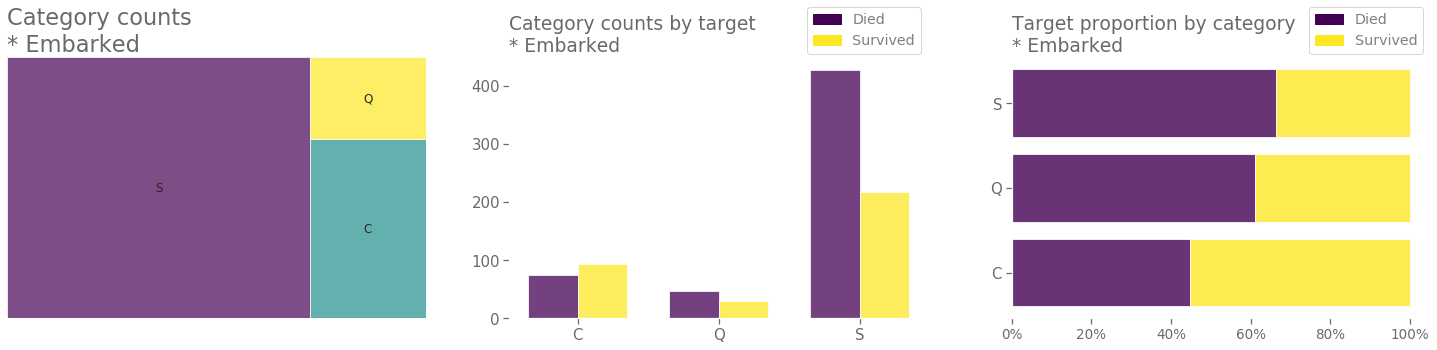

Feature summary Feature vs. target summary Target proportion 
 
 
 Pclass 
 count 
 proportion 
 
 
 
 
 3.000000 
 491.000000 
 55.106622 
 
 
 1.000000 
 216.000000 
 24.242424 
 
 
 2.000000 
 184.000000 
 20.650954 
 
 
 
 
 
 Pclass 
 0 
 1 
 
 
 
 
 1 
 80 
 136 
 
 
 2 
 97 
 87 
 
 
 3 
 372 
 119 
 
 
 
 
 
 Class 
 1 
 2 
 3 
 
 
 
 
 Died 
 37.037037 
 52.717391 
 75.763747 
 
 
 Survived 
 62.962963 
 47.282609 
 24.236253

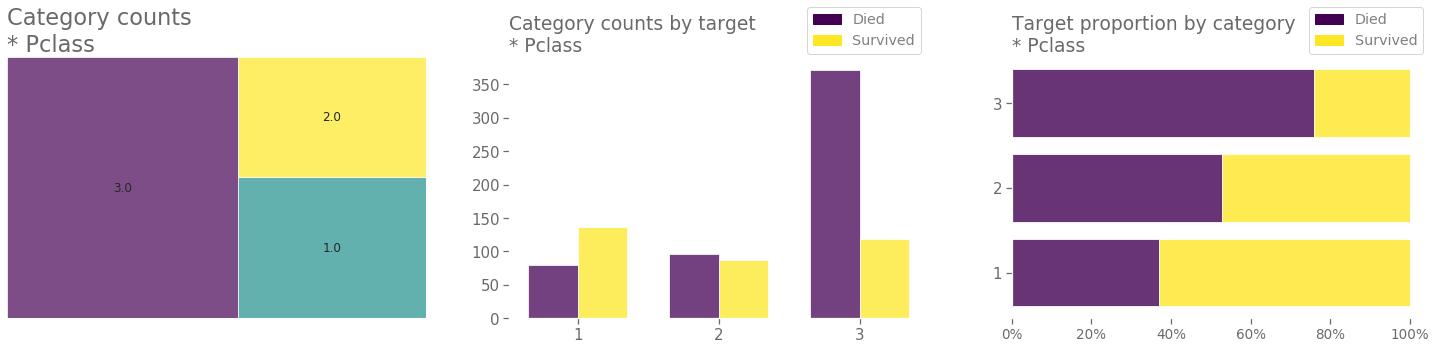

Feature summary Feature vs. target summary Target proportion Statistical test 
 
 
 Sex 
 count 
 proportion 
 
 
 
 
 male 
 577 
 64.758698 
 
 
 female 
 314 
 35.241302 
 
 
 
 
 
 Sex 
 0 
 1 
 
 
 
 
 female 
 81 
 233 
 
 
 male 
 468 
 109 
 
 
 
 
 
 Class 
 female 
 male 
 
 
 
 
 Died 
 25.796178 
 81.109185 
 
 
 Survived 
 74.203822 
 18.890815 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 16.218800 
 0.000000

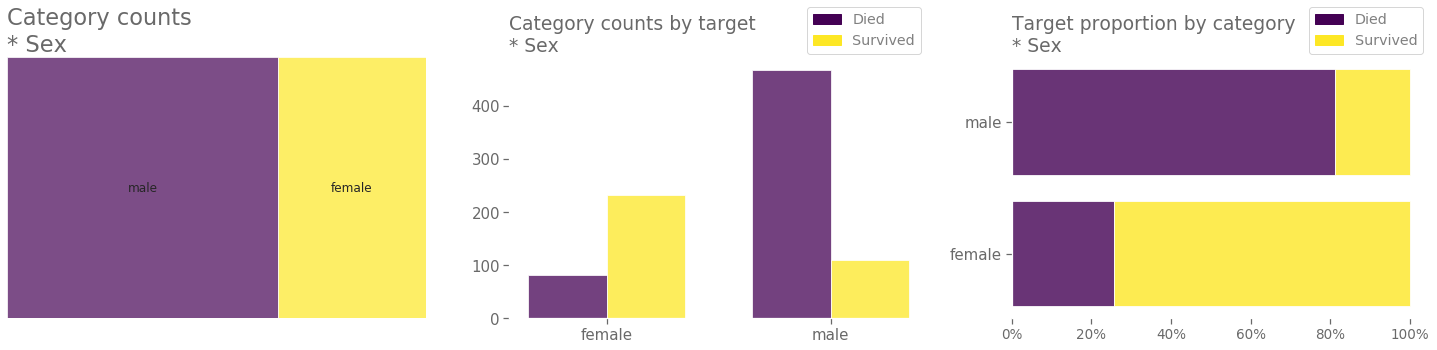

In [9]:
# number features
for feature in train.feature_by_type["category"]:
    train.eda_cat_target_cat_feat(feature=feature, level_count_cap=10, legend_labels=["Died","Survived"])


## Number feature EDA

uni
-dist/kde
- boxplot
- qqplot

bi 
-dist/kde
- boxplot/raincloud
     - https://github.com/pog87/PtitPrince/blob/master/RainCloud_Plot.ipynb

turn box plot into raincloud plot

keep qqplot

<a id = 'number-feature-EDA'></a>

In [ ]:
# number features
for feature in train.feature_by_type["continuous"]:
    train.eda_cat_target_num_feat(feature=feature)

##### Correlation

In [ ]:
# correlation heat map
p = PrettierPlot()
ax = p.make_canvas()
p.pretty_corr_heatmap(df=train.data, annot=True, ax=ax)

In [ ]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plot_orientation='tall',chart_prop=10)
ax = p.make_canvas()
p.pretty_corr_heatmap_target(
    df=train.data, target=train.target, thresh=0.01, annot=True, ax=ax
)

<a id = 'Pair-plot'></a>

In [ ]:
# # pair plot
# p = PrettierPlot(chart_prop=12)
# p.pretty_pair_plot(df=train.data[["Age","Fare","Sex","Pclass","Embarked"]].dropna(), diag_kind="auto")

In [ ]:
# # pair plot
# p = PrettierPlot(chart_prop=12)
# p.pretty_pair_plot(
#     df=train.data.dropna(),
#     diag_kind="kde",
#     target=train.target,
#     columns=["Age", "Fare", "Pclass", "Parch", "SibSp"],
#     legend_labels=["Died", "Survived"],
#     bbox=(2.0, 0.0),
# )

## Faceting

<a id = 'Faceting'></a>

##### object by object

In [ ]:
# facet Pclass vs Embarked
p = PrettierPlot(chart_prop=12)
ax = p.make_canvas(title="Survivorship, embark location by passenger class", y_shift=0.7)
p.pretty_facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="Embarked",
    y=train.target.name,
    split="Pclass",
    y_units="ff",
    ax=ax,
)

In [ ]:
# facet Pclass vs Embarked
p = PrettierPlot(chart_prop=12)
ax = p.make_canvas(title="Survivorship, passenger class by gender", y_shift=0.7)
p.pretty_facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="Pclass",
    y=train.target.name,
    split="Sex",
    y_units="ff",
    ax=ax,
)

In [ ]:
# facet Pclass vs Embarked
p = PrettierPlot(chart_prop=12)
ax = p.make_canvas(title="Survivorship,embark location by gender", y_shift=0.7)
p.pretty_facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="Embarked",
    y=train.target.name,
    split="Sex",
    y_units="ff",
    ax=ax,
)

In [ ]:
#
p = PrettierPlot()
p.pretty_facet_two_cat_point(
    df=train.recombine_data(train.data, train.target),
    x="Sex",
    y=train.target.name,
    split="Pclass",
    cat_col="Embarked",
    aspect=1.0,
    height=5,
    bbox=(1.3, 1.2),
    legend_labels=["1st class", "2nd class", "3rd class"],
)

In [ ]:
#
p = PrettierPlot()
p.pretty_facet_two_cat_point(
    df=train.recombine_data(train.data, train.target).dropna(subset=["Embarked"]),
    x="Embarked",
    y=train.target.name,
    split="Pclass",
    cat_col="Sex",
    aspect=1.0,
    height=5,
    bbox=(1.5, 0.8),
    legend_labels=["1st class", "2nd class", "3rd class"],
)

##### object by number

In [ ]:
#
p = PrettierPlot()
p.pretty_facet_cat_num_hist(
    df=train.recombine_data(train.data, train.target),
    split=train.target.name,
    legend_labels=["Died", "Lived"],
    cat_row="Sex",
    cat_col="Embarked",
    num_col="Age",
    bbox=(1.9, 1.0),
    height=4,
    aspect=1,
)

In [ ]:
#
p = PrettierPlot(chart_prop=15)
p.pretty_facet_cat_num_scatter(
    df=train.recombine_data(train.data, train.target),
    split=train.target.name,
    legend_labels=["Died", "Lived"],
    cat_row="Sex",
    cat_col="Embarked",
    x="Fare",
    y="Age",
    bbox=(1.9, 1.0),
    height=4,
    aspect=1,
)

## Target variable evaluation

<a id = 'Target-variable-evaluation'></a>

In [ ]:
# null score
pd.Series(train.target).value_counts(normalize=True)

# Data preparation

<a id = 'Data-preparation'></a>

## Missing data


<a id = 'Missing-data'></a>

##### Training

In [ ]:
# evaluate missing data
train.eda_missing_summary()

In [ ]:
# missingno matrix
msno.matrix(train.data)

In [ ]:
# missingno bar
msno.bar(train.data)

In [ ]:
# missingno heatmap
msno.heatmap(train.data)

In [ ]:
# missingno dendrogram
msno.dendrogram(train.data)

##### Validation

In [ ]:
# evaluate missing data
valid.eda_missing_summary()

In [ ]:
# missingno matrix
msno.matrix(valid.data)

In [ ]:
# missingno bar
msno.bar(valid.data)

In [ ]:
# missingno heatmap
msno.heatmap(valid.data)

In [ ]:
# missingno dendrogram
msno.dendrogram(valid.data)

##### Training vs. validation


In [ ]:
# compare feature with missing data
train.missing_col_compare(train=train.data, validation=valid.data)

##### Impute

In [ ]:
# impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["Age","Pclass"]),
        ContextImputer(null_col="Age", context_col="Pclass", strategy="mean")
    )),
    ("fare", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["Fare","Pclass"]),
        ContextImputer(null_col="Fare", context_col="Pclass")
    )),
    ("embarked", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasPipeline(impute.SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["Cabin"]),
        PandasPipeline(impute.SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Fare","Embarked","Cabin"])
    )),
])

train.data = impute_pipe.fit_transform(train.data)
valid.data = impute_pipe.transform(valid.data)

In [ ]:
train.eda_missing_summary()

In [ ]:
valid.eda_missing_summary()

## Feature engineering

<a id = 'Feature-engineering'></a>

### Handcrafted

<a id = 'Handcrafted'></a>

In [ ]:
### training data
# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in train.data["Name"]]
train.data["Title"] = pd.Series(
    title,
    index=train.data.index,
    dtype="object",
)
train.data["Title"] = train.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
train.data["Title"] = train.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
train.data["Title"] = train.data["Title"].astype("object")

# distill cabin feature
train.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in train.data["Cabin"]],
    index=train.data.index,
    dtype="object",
)

# family size features and binning
train.data["FamilySize"] = train.data["SibSp"] + train.data["Parch"] + 1
train.data["FamilySize"] = train.data["FamilySize"].astype("int64")

# # update feature_by_type and drop columns
# train.feature_by_type_update(columns_to_drop=["Name","Cabin"])

In [ ]:
### validation data
# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in valid.data["Name"]]
valid.data["Title"] = pd.Series(
    title,
    index=valid.data.index,
    dtype="object",
)
valid.data["Title"] = valid.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
valid.data["Title"] = valid.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
valid.data["Title"] = valid.data["Title"].astype("object")

# distill cabin feature
valid.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in valid.data["Cabin"]],
    index=valid.data.index,
    dtype="object",
)

# additional features
valid.data["FamilySize"] = valid.data["SibSp"] + valid.data["Parch"] + 1
valid.data["FamilySize"] = valid.data["FamilySize"].astype("int64")

# # update feature_by_type and drop columns
# valid.feature_by_type_update(columns_to_drop=["Name","Cabin"])

### Polynomial features

<a id = 'Polynomial-features'></a>

In [ ]:
# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", pipeline.make_pipeline(
        DataFrameSelector(include_dtypes=["number"]),
        PandasPipeline(preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False))
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(include_dtypes=["object"], exclude_columns=["Name","Cabin"]),
    )),
])

# train.data = polynomial_pipe.fit_transform(train.data)
# valid.data = polynomial_pipe.transform(valid.data)

# train.feature_by_type_update()
# valid.feature_by_type_update()

### Encoding

<a id = 'Encoding'></a>

In [ ]:
### training data
# counts of unique values in training data string columns
train.data[train.feature_by_type["object"]].apply(pd.Series.nunique, axis=0)

In [ ]:
### training data
# print unique values in each object columns
for col in train.data[train.feature_by_type["object"]]:
    print(col, np.unique(train.data[col]))

In [ ]:
### validation data
# counts of unique values in validation data string columns
valid.data[valid.feature_by_type["object"]].apply(pd.Series.nunique, axis=0)

In [ ]:
### validation data
# print unique values in each object columns
for col in valid.data[valid.feature_by_type["object"]]:
    print(col, np.unique(valid.data[col]))

In [ ]:
# identify values that are present in the training data but not the validation data, and vice versa
for col in train.feature_by_type["object"]:
    if col not in ["Name", "Cabin"]:
        train_values = train.data[col].unique()
        valid_values = valid.data[col].unique()

        train_diff = set(train_values) - set(valid_values)
        valid_diff = set(valid_values) - set(train_values)

        if len(train_diff) > 0 or len(valid_diff) > 0:
            print("\n\n*** " + col)
            print("Value present in training data, not in validation data")
            print(train_diff)
            print("Value present in validation data, not in training data")
            print(valid_diff)

In [ ]:
#
ordinal_columns = ["Pclass"]
nominal_columns = ["CabinQuarter","Embarked","Sex","Title"]

ordinal_encodings = [
        [1, 2, 3], # Pclass
    ]

# encode pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", pipeline.make_pipeline(
        DataFrameSelector(include_columns=nominal_columns),
        PandasPipeline(preprocessing.OneHotEncoder(drop="first")),
    )),
    ("ordinal", pipeline.make_pipeline(
        DataFrameSelector(include_columns=ordinal_columns),
        PandasPipeline(preprocessing.OrdinalEncoder(categories=ordinal_encodings)),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_columns=nominal_columns + ordinal_columns),
    )),
])

# train.data = encode_pipe.fit_transform(train.data)
# valid.data = encode_pipe.transform(valid.data)

# train.feature_by_type_update()
# valid.feature_by_type_update()

In [ ]:
#
target_encode_pipe = PandasFeatureUnion([
    ("target", pipeline.make_pipeline(
        DataFrameSelector(
            include_dtypes=["number"]            
        ),
        KFoldTargetEncoder(
            target=train.target,
            cv=model_selection.KFold(n_splits=5, shuffle=False, random_state=0),
            n_bins = 5,
            #nBins = {"Age" : 5, "Fare" : 10},
            drop_bin_columns=True,
            drop_original_columns=False,
        )
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(
            exclude_dtypes=["number"],            
        ),
    )),
])

# train.data = target_encode_pipe.fit_transform(train.data)
# valid.data = target_encode_pipe.transform(valid.data)


### test

In [ ]:
from copy import deepcopy
X = deepcopy(train)
y = deepcopy(valid)

the_pipe = pipeline.Pipeline([
    ("impute", impute_pipe),
    ("poly", polynomial_pipe),
    ("encode", encode_pipe),
#     ("target_encode", target_encode_pipe),
    
])

# train.data = the_pipe.fit_transform(train.data)
# valid.data = the_pipe.transform(valid.data)
# display(X.data[X.data.columns][:10])
# display(y.data[X.data.columns][:10])

X.data = the_pipe.fit_transform(X.data)
y.data = the_pipe.transform(y.data)
# display(X.data[X.data.columns][:10])
# display(y.data[X.data.columns][:10])

class KFoldTargetEncoder(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, target, cv, n_bins=5, drop_bin_columns=True, drop_original_columns=False):
        self.target = target
        self.cv = cv
        self.transform_train = False
        self.n_bins = n_bins
        self.drop_bin_columns = drop_bin_columns
        self.drop_original_columns = drop_original_columns

    def fit(self, X, y=None):
        self.columns = X.columns
        self.stats = {}
        self.binners = {}

        # indentify any number columns in input dataset
        self.number_columns = X.select_dtypes("number").columns.tolist()
        self.number_columns = []
        
        print(self.number_columns)
        return self

    def transform(self, X, y=None):
        if not self.transform_train:
            # combine input columns and target
            X = X.merge(self.target, left_index=True, right_index=True)

            # add empty columns to input dataset and set as number
            for col in self.columns:
                X[col + "_" + "target_encoded"] = np.nan
                X[col + "_" + "target_encoded"] = pd.to_number(
                    X[col + "_" + "target_encoded"]
                )

            # if column is number, then bin column prior to target encoding
            for col in self.number_columns:
                if isinstance(self.n_bins, dict):
                    binner = preprocessing.KBinsDiscretizer(
                        n_bins=self.n_bins[col], encode="ordinal"
                    )
                    # X[col] = binner.fit_transform(X[[col]])
                    X[
                        "{}_{}_bins".format(col, self.n_bins[col])
                    ] = binner.fit_transform(X[[col]])

                    # store binner transformer for each column
                    self.binners[col] = binner

                else:
                    binner = preprocessing.KBinsDiscretizer(
                        n_bins=self.n_bins, encode="ordinal"
                    )
                    # X[col] = binner.fit_transform(X[[col]])
                    X["{}_{}_bins".format(col, self.n_bins)] = binner.fit_transform(
                        X[[col]]
                    )

                    # store binner transformer for each column
                    self.binners[col] = binner

            # iterate through cv indices
            for train_ix, valid_ix in self.cv.split(X):
                x_train, x_valid = X.iloc[train_ix], X.iloc[valid_ix]

                # update rows with out of fold averages
                for col in self.columns:
                    if col in self.number_columns:
                        if isinstance(self.n_bins, dict):
                            X.loc[
                                X.index[valid_ix], col + "_" + "target_encoded"
                            ] = x_valid["{}_{}_bins".format(col, self.n_bins[col])].map(
                                x_train.groupby(
                                    "{}_{}_bins".format(col, self.n_bins[col])
                                )[self.target.name].mean()
                            )
                        else:
                            X.loc[
                                X.index[valid_ix], col + "_" + "target_encoded"
                            ] = x_valid["{}_{}_bins".format(col, self.n_bins)].map(
                                x_train.groupby("{}_{}_bins".format(col, self.n_bins))[
                                    self.target.name
                                ].mean()
                            )
                    else:
                        X.loc[
                            X.index[valid_ix], col + "_" + "target_encoded"
                        ] = x_valid[col].map(
                            x_train.groupby(col)[self.target.name].mean()
                        )

            # ensure number data type
            for col in self.columns:
                X[col + "_" + "target_encoded"] = pd.to_number(
                    X[col + "_" + "target_encoded"]
                )

            # collect average values for transformation of unseen data
            for col in self.columns:
                if col in self.number_columns:
                    if isinstance(self.n_bins, dict):
                        self.stats[col] = X.groupby(
                            "{}_{}_bins".format(col, self.n_bins[col])
                        )["{}_target_encoded".format(col)].mean()
                    else:
                        self.stats[col] = X.groupby(
                            "{}_{}_bins".format(col, self.n_bins)
                        )["{}_target_encoded".format(col)].mean()
                else:
                    self.stats[col] = X.groupby(col)[
                        "{}_target_encoded".format(col)
                    ].mean()

            # flip transform_train switch to indicate that fitting has occurred
            # ensure future transform calls will go to the else branch of the conditional
            self.transform_train = True

            # drop target column
            X = X.drop(self.target.name, axis=1)

            # conditionally drop original and/or binned columns
            if self.drop_original_columns:
                X = X.drop(self.columns, axis=1)
            if self.drop_bin_columns:
                X = X.drop(X.columns[X.columns.str.contains("_bins")], axis=1)
        else:
            # ieterate through all columns in the summary stats dict
            for col in self.stats.keys():

                # add shell column and update by mapping encodings to object values or bins
                X["{}_target_encoded".format(col)] = np.nan

                # perform binning on number columns
                if col in self.number_columns:
                    binner = self.binners[col]

                    if isinstance(self.n_bins, dict):

                        X[
                            col + "_" + str(self.n_bins[col]) + "_bins"
                        ] = binner.transform(X[[col]])

                        X["{}_target_encoded".format(col)] = np.where(
                            X["{}_target_encoded".format(col)].isnull(),
                            X["{}_{}_bins".format(col, self.n_bins[col])].map(
                                self.stats[col]
                            ),
                            X["{}_target_encoded".format(col)],
                        )
                    else:
                        X[col + "_" + str(self.n_bins) + "_bins"] = binner.transform(
                            X[[col]]
                        )

                        X["{}_target_encoded".format(col)] = np.where(
                            X["{}_target_encoded".format(col)].isnull(),
                            X["{}_{}_bins".format(col, self.n_bins)].map(
                                self.stats[col]
                            ),
                            X["{}_target_encoded".format(col)],
                        )
                else:
                    X["{}_target_encoded".format(col)] = np.where(
                        X["{}_target_encoded".format(col)].isnull(),
                        X[col].map(self.stats[col]),
                        X["{}_target_encoded".format(col)],
                    )

            # conditionally drop original and/or binned columns
            if self.drop_original_columns:
                X = X.drop(self.columns, axis=1)
            if self.drop_bin_columns:
                X = X.drop(X.columns[X.columns.str.contains("_bins")], axis=1)
        return X

    
    
    
#
target_encode_pipe = PandasFeatureUnion([
    ("target", pipeline.make_pipeline(
        DataFrameSelector(
            include_dtypes=["number"]            
        ),
        KFoldTargetEncoder(
            target=train.target,
            cv=model_selection.KFold(n_splits=5, shuffle=False, random_state=0),
            n_bins = 5,
            #nBins = {"Age" : 5, "Fare" : 10},
            drop_bin_columns=False,
            drop_original_columns=False,
        )
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(
            exclude_dtypes=["number"],            
        ),
    )),
])

# X.data = target_encode_pipe.fit_transform(X.data[["CabinQuarter_B","CabinQuarter_C","CabinQuarter_E","Age"]])
# y.data = target_encode_pipe.transform(y.data)
# display(X.data[["CabinQuarter_B","CabinQuarter_B_target_encoded","CabinQuarter_C","CabinQuarter_C_target_encoded","CabinQuarter_E","CabinQuarter_E_target_encoded","Age","Age_target_encoded"]][:50])


## Feature transformation

<a id = 'Feature-transformation'></a>

### Skew correction

<a id = 'Skew-correction'></a>

In [ ]:
### training data
# evaluate skew of number features
train.skew_summary()

In [ ]:
### validation data
# evaluate skew of number features
valid.skew_summary()

In [ ]:
# skew correction pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", pipeline.make_pipeline(
        DataFrameSelector(train.feature_by_type["number"]),
        DualTransformer(),
    )),    
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(list(set(train.data.columns).difference(train.feature_by_type["number"]))),
    )),
])

train.data = skew_pipe.fit_transform(train.data)
valid.data = skew_pipe.transform(valid.data)

train.feature_by_type_update()
valid.feature_by_type_update()

### Scaling

<a id = 'Scaling'></a>

In [ ]:
#
scale_pipe = PandasFeatureUnion([
    ("scale", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["number"]),
        PandasPipeline(preprocessing.StandardScaler())
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_columns=["number"]),
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.feature_by_type_update()
valid.feature_by_type_update()

## Outliers


<a id = 'Outliers'></a>

In [ ]:
# identify outliers using IQR
train_pipe = pipeline.Pipeline([
    ("outlier",train.OutlierIQR(
                outlier_count=10,
                iqr_step=1.5,
                features=train.feature_by_type["number"],
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
iqr_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers_))
print(iqr_outliers)

In [ ]:
# identify outliers using Isolation Forest
clf = ensemble.IsolationForest(
    behaviour="new",
    max_samples=train.data.shape[0],
    random_state=0,
    contamination=0.01,
)
clf.fit(train.data[train.data.columns])
preds = clf.predict(train.data[train.data.columns])

# evaluate index values
mask = np.isin(preds, -1)
if_outliers = np.array(train.data[mask].index)
print(if_outliers)

In [ ]:
# identify outliers using extended isolation forest
train_pipe = pipeline.Pipeline([
    ("outlier",train.ExtendedIsoForest(
                columns=train.feature_by_type["number"],
                n_trees=100,
                sample_size=256,
                extension_level=1,
                anomalies_ratio=0.03,
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
eif_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers_))
print(eif_outliers)

In [ ]:
# identify outliers that are identified in multiple algorithms
outliers = reduce(np.intersect1d, (iqr_outliers, if_outliers, eif_outliers))
# outliers = reduce(np.intersect1d, (if_outliers, eif_outliers))
print(outliers)

In [ ]:
# review outlier identification summary
outlier_summary = train.outlier_summary(iqr_outliers=iqr_outliers,
                             if_outliers=if_outliers,
                             eif_outliers=eif_outliers
                            )
outlier_summary[outlier_summary["count"] >= 3]

In [ ]:
# remove outlers from predictors and response
outliers = np.array([258, 305, 438, 679, 737, 745])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

# Feature importance

<a id = 'Feature-importance'></a>

In [ ]:
# generate feature importance summary
estimators = [
    lightgbm.LGBMClassifier,
    ensemble.RandomForestClassifier,
#     ensemble.GradientBoostingClassifier,
#     ensemble.ExtraTreesClassifier,
#     ensemble.AdaBoostClassifier,
    xgboost.XGBClassifier,
]

fs = train.FeatureSelector(
    data=train.data, target=train.target, estimators=estimators, rank=True
)
feature_selector_summary = fs.feature_selector_suite()
feature_selector_summary[:20]

In [ ]:
# calculate cross-validation performance
estimators = [
#     svm.SVC,
    lightgbm.LGBMClassifier,
#     linear_model.LogisticRegression,
    xgboost.XGBClassifier,
    ensemble.RandomForestClassifier,
#     ensemble.GradientBoostingClassifier,
#     ensemble.AdaBoostClassifier,
#     ensemble.ExtraTreesClassifier,
#     neighbors.KNeighborsClassifier,
]

cv_summary = fs.feature_selector_cross_val(
    feature_selector_summary = None,
#     feature_selector_summary = pd.read_csv("featureSelectionSummary_20191028_173422.csv", index_col=0),
    estimators=estimators,
    scoring=["accuracy"],
    n_folds=5,
    step=1,
    n_jobs=12,
)

###### Accuracy

In [ ]:
# visualize CV performance for diminishing feature set
fs.feature_selector_results_plot(
    metric="accuracy",
#     cv_summary= pd.read_csv("cv_summary_20191028_173925.csv", index_col=0),
#     feature_selector_summary=pd.read_csv("featureSelectionSummary_20191028_173422.csv", index_col=0),
    title_scale=0.8,
)

In [ ]:
cross_val_features_df = fs.create_cross_val_features_df(
    metric="accuracy",
#     cv_summary= pd.read_csv("cv_summary_20191028_173925.csv", index_col=0),
#     feature_selector_summary=pd.read_csv("featureSelectionSummary_20191028_173422.csv", index_col=0),
)
cross_val_features_df#[:5]

In [ ]:
cross_val_feature_dict = fs.create_cross_val_features_dict(
    cross_val_features_df=cross_val_features_df
)
cross_val_feature_dict

# Modeling

<a id = 'Modeling'></a>

## Data preparation

<a id = 'Data-preparation-1'></a>

In [ ]:
#################################################################################
# import training data
df_train, df_valid = data.titanic()
train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId", "Ticket"],
    identify_as_object=["Pclass"],
    target_type="object",
)

# import validation data
valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId", "Ticket"],
    identify_as_object=["Pclass"],
)

#################################################################################
# impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", pipeline.make_pipeline(
        DataFrameSelector(["Age","Pclass"]),
        ContextImputer(null_col="Age", context_col="Pclass", strategy="mean")
    )),
    ("fare", pipeline.make_pipeline(
        DataFrameSelector(["Fare","Pclass"]),
        ContextImputer(null_col="Fare", context_col="Pclass")
    )),
    ("embarked", pipeline.make_pipeline(
        DataFrameSelector(["Embarked"]),
        PandasPipeline(impute.SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", pipeline.make_pipeline(
        DataFrameSelector(["Cabin"]),
        PandasPipeline(impute.SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(list(set(train.data.columns).difference(["Age","Fare","Embarked","Cabin"]))),
    )),
])

train.data = impute_pipe.fit_transform(train.data)
valid.data = impute_pipe.transform(valid.data)

#################################################################################
# feature engineering - training

# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in train.data["Name"]]
train.data["Title"] = pd.Series(
    title,
    index=train.data.index,
    dtype="object",
)
train.data["Title"] = train.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
train.data["Title"] = train.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
train.data["Title"] = train.data["Title"].astype("object")

# distill cabin feature
train.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in train.data["Cabin"]],
    index=train.data.index,
    dtype="object",
)

# family size features
train.data["FamilySize"] = pd.to_number(train.data["SibSp"]) + pd.to_number(train.data["Parch"]) + 1
train.data["FamilySize"] = train.data["FamilySize"].astype("object")

train.feature_by_type_update(columns_to_drop=["Name","Cabin"])

#################################################################################
# feature engineering - validation

# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in valid.data["Name"]]
valid.data["Title"] = pd.Series(
    title,
    index=valid.data.index,
    dtype="object"
)
valid.data["Title"] = valid.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
valid.data["Title"] = valid.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
valid.data["Title"] = valid.data["Title"].astype("object")

# distill cabin feature
valid.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in valid.data["Cabin"]],
    index=valid.data.index,
    dtype="object",
)

# additional features
valid.data["FamilySize"] = pd.to_number(valid.data["SibSp"]) + pd.to_number(valid.data["Parch"]) + 1
valid.data["FamilySize"] = valid.data["FamilySize"].astype("object")

valid.feature_by_type_update(columns_to_drop=["Name","Cabin"])

# #################################################################################
# # feature transformation pipeline
# nominal_columns = ["Embarked","Sex","CabinQuarter","Title"]

# ordinal_columns = ["Pclass"]
# ordinal_encodings = [
#         [0, 1, 2, 3], # Pclass 
#     ]

# transform_pipe = PandasFeatureUnion([
#     ("ordinal", pipeline.make_pipeline(
#         DataFrameSelector(ordinal_columns),
#         PandasPipeline(preprocessing.OrdinalEncoder(categories=ordinal_encodings)),
#     )),
#     ("nominal", pipeline.make_pipeline(
#         DataFrameSelector(nominal_columns),
#         PandasPipeline(preprocessing.OneHotEncoder(drop="first")),
#     )),
#     ("number", pipeline.make_pipeline(
#         DataFrameSelector(train.feature_by_type["number"]),
#         PandasPipeline(preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
# #         DualTransformer(),
#         PandasPipeline(preprocessing.StandardScaler())
#     )),
#     ("diff", pipeline.make_pipeline(
#         DataFrameSelector(list(set(train.data.columns).difference(nominal_columns + ordinal_columns + train.feature_by_type["number"]))),
#     )),
# ])

# train.data = transform_pipe.fit_transform(train.data)
# valid.data = transform_pipe.transform(valid.data)

# train.feature_by_type_update()
# valid.feature_by_type_update()

# #################################################################################
# # remove outliers
# outliers = np.array([258, 305, 438, 679, 737, 745])
# train.data = train.data.drop(outliers)
# train.target = train.target.drop(index=outliers)

# # # accuracy >= 7
# # best_columns = ['Age*Fare','Title_2','Fare*FamilySize','Sex_male','Fare','Pclass','CabinQuarter_X']
# # train.data = train.data[best_columns]
# # valid.data = valid.data[best_columns]

print('completed')

#### Category encoding

- to do
    - feature engineering
        - binning
            - optimal binning (the maxhalfford.github site)
            - object features
                - not necessary
            - number features
                - for each value, replace with the bin label
        - number-specific transformations
            - ratios/quotients
            - sums
            - products
            - differences
    - model evaluation
        - incorrect predictions
            - false positives
            - false negatives

__cross validation__

- 5 fold
- use stratified k-fold when the test data is not in the future


- http://blog.kaggle.com/2016/04/08/homesite-quote-conversion-winners-write-up-1st-place-kazanova-faron-clobber/
- https://www.kaggle.com/matleonard/object-encodings
- http://www.kazanovaforanalytics.com/software.html
- https://github.com/Far0n/xgbfi
- https://towardsdatascience.com/my-secret-sauce-to-be-in-top-2-of-a-kaggle-competition-57cff0677d3c
- https://contrib.scikit-learn.org/object-encoding/
- https://github.com/scikit-learn-contrib/object-encoding/tree/master/category_encoders
- https://stats.idre.ucla.edu/r/library/r-library-contrast-coding-systems-for-object-variables/
- http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging/target-encoding.html
- https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b






----------------------------------------------------------------------------------------------------------


if it's a numeic column, but you don't want to bin it
- max level cap? If there there a < X levels in number column (or if it's a limited # of ints) just make it orrinal
- pass None to dict
- unique values divided by number of bins
- or is ordinal?

In [ ]:
from collections import defaultdict

X = train.data
X_t = train.target
Y = valid.data

number_columns = ["Age","Fare"]
ordinal_columns = ["Pclass","FamilySize","Parch","SibSp"]
nominal_columns = ["CabinQuarter","Embarked","Sex","Title"]

ordinal_encodings = [
        [1, 2, 3], # Pclass
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], # FamilySize
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], # Parch
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], # SibSp
    ]

impute_pipe = PandasFeatureUnion([
    ("catcount", pipeline.make_pipeline(
        DataFrameSelector(ordinal_columns + nominal_columns),
        PandasPipeline(ce.CountEncoder(return_df=False))
    )),
    ("nominal", pipeline.make_pipeline(
        DataFrameSelector(nominal_columns),
        PandasPipeline(preprocessing.OneHotEncoder(drop="first")),
    )),
    ("ordinal", pipeline.make_pipeline(
        DataFrameSelector(ordinal_columns),
        PandasPipeline(preprocessing.OrdinalEncoder(categories=ordinal_encodings)),
    )),
    ("num3", pipeline.make_pipeline(
        DataFrameSelector(ordinal_columns + nominal_columns + number_columns),
        KFoldTargetEncoder(
            target=train.target,
            cv=model_selection.KFold(n_splits=5, shuffle=False, random_state=0),
            n_bins = 5,
#             nBins = {"Age" : 5, "Fare" : 10},
            drop_bin_columns=False,
            drop_original_columns=True,
        )
    )),
    ("norm", pipeline.make_pipeline(
        DataFrameSelector(number_columns),
        PandasPipeline(preprocessing.QuantileTransformer(output_distribution="normal")),
    )),
    ("uni", pipeline.make_pipeline(
        DataFrameSelector(number_columns),
        PandasPipeline(preprocessing.QuantileTransformer(output_distribution="uniform")),
    )),
    ("select2", pipeline.make_pipeline(
        DataFrameSelector(["Embarked","Age","Fare"]),
    )),
#     ("nu2", pipeline.make_pipeline(
#         DataFrameSelector(["Age","Fare"]),
#         PandasPipeline(preprocessing.KBinsDiscretizer(n_bins=10, encode="ordinal")),
#     )),
#     ("binar", pipeline.make_pipeline(
#         DataFrameSelector(["Embarked","CabinQuarter"]),
#         PandasPipeline(ce.BinaryEncoder(return_df=False))
#     )),
])

X = impute_pipe.fit_transform(train.data)
y = impute_pipe.transform(valid.data)
display(X[:10])
display(y[:5])

In [ ]:
train.feature_by_type

In [ ]:
train.fe

In [ ]:
X["Age_Quantile_normal"].hist()

In [ ]:
X["Age_target_encoded"].hist()

In [ ]:
X["Age_Quantile_uniform"].hist()

In [ ]:
import itertools  

df = X[["Age","Fare","Age_Quantile_normal","Fare_Quantile_uniform"]]

# create list of tuples containing columns pairs
pairs = list(itertools.product(df, df))

# remove tuples if both items in pair are the same
for x in pairs:
    if len(set(x)) == 1:
        pairs = [i for i in pairs if i != x]

# if two tuples contain the same two items, keep only one
for x in pairs:
    if pairs[0][::-1] in pairs[1:]:
        pairs = pairs[1:]

#
for x in pairs:
    df["{} + {}".format(x[0],x[1])] = df[x[0]] + df[x[1]]
    df["{} / {}".format(x[0],x[1])] = df[x[0]] / df[x[1]]
    df["{} * {}".format(x[0],x[1])] = df[x[0]] * df[x[1]]

df = df.merge(train.target, left_index=True, right_index=True)

XX = df.iloc[:,:-1]
YY = df.iloc[:,-1]

In [ ]:
results = pd.DataFrame(columns=["col","score"])

import xgboost
import sklearn.linear_model as linear_model
for x in XX.columns:
#     obj = linear_model.LogisticRegression()
    obj = xgboost.XGBClassifier()

    obj.fit(XX[[x]], YY)
    preds = obj.predict(XX[[x]])
    
    acc = sum(YY == preds) / len(YY)
    results.loc[len(results)] = [x, acc]
results

###### target

In [ ]:
age = d[["Age"]].drop_duplicates()
ix = np.arange(1, len(age.index)+1)
plt.plot(ix, age)

In [ ]:
fare = d[["Fare"]].drop_duplicates()
ix = np.arange(1, len(fare.index)+1)
plt.plot(ix, fare)

In [ ]:
d[["Age"]].drop_duplicates()

In [ ]:
X.filter(regex="RAD|CHAS")[:20]

## Bayesian hyper-parameter optimization

<a id = 'Bayesian-hyper-parameter-optimization'></a>

In [ ]:
# parameter space
all_space = {
    "lightgbm.LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "boosting_type": hp.choice("boosting_type", ["dart"]),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "learning_rate": hp.uniform("learning_rate", 0.15, 0.25),
        "max_depth": hp.choice("max_depth", np.arange(4, 20, dtype=int)),
        "min_child_samples": hp.quniform("min_child_samples", 50, 150, 5),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "num_leaves": hp.quniform("num_leaves", 30, 70, 1),
        "reg_alpha": hp.uniform("reg_alpha", 0.75, 1.25),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.quniform("subsample_for_bin", 100000, 350000, 20000),
    },
    "linear_model.LogisticRegression": {
        "C": hp.uniform("C", 0.04, 0.1),
        "penalty": hp.choice("penalty", ["l1"]),
    },
    "xgboost.XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "gamma": hp.quniform("gamma", 0.0, 10, 0.05),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.01),
        "max_depth": hp.choice("max_depth", np.arange(2, 15, dtype=int)),
        "min_child_weight": hp.quniform("min_child_weight", 2.5, 7.5, 1),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.4, 0.7),
    },
    "ensemble.RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 10, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 8000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(15, 25, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 20, dtype=int)),
    },
    "ensemble.GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 11, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.09, 0.01),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "ensemble.AdaBoostClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "learning_rate": hp.quniform("learning_rate", 0.1, 0.25, 0.01),
        "algorithm": hp.choice("algorithm", ["SAMME"]),
    },
    "ensemble.ExtraTreesClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 15, dtype=int)),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(4, 30, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 20, dtype=int)),
        "max_features": hp.choice("max_features", ["auto"]),
        "criterion": hp.choice("criterion", ["entropy"]),
    },
    "svm.SVC": {
        "C": hp.uniform("C", 4, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovr"]),
        "gamma": hp.uniform("gamma", 0.00000001, 1.5),
    },
    "neighbors.KNeighborsClassifier": {
        "algorithm": hp.choice("algorithm", ["ball_tree", "brute"]),
        "n_neighbors": hp.choice("n_neighbors", np.arange(1, 15, dtype=int)),
        "weights": hp.choice("weights", ["uniform"]),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    data=train.data,
    target=train.target,
    columns=cross_val_feature_dict,
    scoring="accuracy",
    n_folds=2,
    n_jobs=8,
    iters=1,
    verbose=0,
)

##### Model loss by iteration

In [ ]:
# read scores summary table
bayes_optim_summary = pd.read_csv("bayesOptimizationSummary_accuracy_20191028_174038.csv", na_values="nan")
bayes_optim_summary[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary, estimator=estimator)

##### Parameter selection by iteration

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.modelParamPlot(
        bayes_optim_summary=bayes_optim_summary,
        estimator=estimator,
        all_space=all_space,
        n_iter=100,
#         chart_prop=15,
        title_scale=0.8
    )

In [ ]:
sample_space = {
                'param': hp.uniform('param', np.log(0.4), np.log(0.6))
#     "": 0.000001 + hp.uniform("gamma", 0.000001, 10)
    #             'param2': hp.loguniform('param2', np.log(0.001), np.log(0.01))
}

train.sample_plot(sample_space, 1000)

In [ ]:
# pair-wise comparison
p = PrettierPlot(chart_prop=12)
p.pretty_pair_plot_custom(
    df=train.unpack_bayes_optim_summary(bayes_optim_summary, "lightgbm.LGBMClassifier"),
    columns=["colsample_bytree", "learning_rate", "iteration","iterLoss"],
    gradient_col="iteration",
    color=style.style_grey
)

## Model performance evaluation - standard models

<a id = 'Model-performance-evaluation-standard-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(bayes_optim_summary=bayes_optim_summary, num_models=1)
top_models

In [ ]:
# classification panel, single model
# estimator = "svm.SVC"; model_iter = 1224
# estimator = 'ensemble.GradientBoostingClassifier'; model_iter = 590
estimator = 'xgboost.XGBClassifier'; model_iter = 1256

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

train.classification_panel(
    model=model,
    X_train=train.data,
    y_train=train.target,
    cm_labels=["Dies", "Survives"],
    n_folds=5,
    title_scale=0.9
)

In [ ]:
# create classification reports for training data
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.classification_panel(
            model=model, X_train=train.data, y_train=train.target, cm_labels=['Dies', 'Survives'], n_folds=4
        )

## Model explanability

<a id = 'Feature-importance'></a>

In [ ]:
# 
# estimator = "ensemble.ExtraTreesClassifier"; model_iter = 145
# estimator = "svm.SVC"; model_iter = 135
estimator = "ensemble.GradientBoostingClassifier"; model_iter = 1385

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)
model.fit(train.data.values, train.target.values)

##### Permutation importance

In [ ]:
# permutation importance - how much does performance decrease when shuffling a certain feature?
perm = PermutationImportance(model.model, random_state=1).fit(train.data, train.target)
eli5.show_weights(perm, feature_names=train.data.columns.tolist())

##### SHAP values - training data

###### Force plots - single observations

In [ ]:
# SHAP force plots for individual observations
for i in train.data.index[:5]:
    train.single_shap_viz_tree(obsIx=i, model=model, data=train.data, target=train.target)

###### Force plots - multiple observations

In [ ]:
# SHAP force plot a set of data
visual = train.multi_shap_viz_tree(obs_ixs=train.data.index, model=model, data=train.data)
visual

###### Dependence plots

In [ ]:
# generate SHAP values for set of observations
obs_data, _, obs_shap_values = train.multi_shap_value_tree(
    obs_ixs=train.data.index, model=model, data=train.data
)

In [ ]:
# SHAP dependence plot grid
# grid_features = ["Pclass", "Age", "Fare", "SibSp","Parch"]
grid_features = ['Age*Fare','Title_2','Fare*FamilySize','Sex_male','Fare','Pclass','CabinQuarter_X']

train.shap_dependence_grid(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    grid_features=grid_features,
    all_features=train.data.columns,
    dot_size=35,
    alpha=0.5,
)

In [ ]:
# single SHAP dependence plot
p = PrettierPlot()
ax = p.make_canvas()

train.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="Fare",
    color_feature="Sex_male",
    feature_names=train.data.columns,
    dot_size=50,
    alpha=0.5,
    ax=ax
)


In [ ]:
# SHAP dependence plots for all feature relative to an interaction feature
feature_names = train.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

for top_ix in top_shap:
    p = PrettierPlot()
    ax = p.make_canvas()
    
    train.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Fare",
        feature_names=feature_names,
        dot_size=50,
        alpha=0.5,
        ax=ax,
    )

###### Summary plots

In [ ]:
# SHAP summary plot
train.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=train.data.columns,
    )

##### SHAP values - validation data

###### Force plots - single observations

In [ ]:
# SHAP force plots for individual observations
for i in valid.data.index[:2]:
    valid.single_shap_viz_tree(obsIx=i, model=model, data=valid.data)

###### Force plots - multiple observations

In [ ]:
# SHAP force plot a set of data
visual = valid.multi_shap_viz_tree(obs_ixs=valid.data.index, model=model, data=valid.data)
visual

###### Dependence plots

In [ ]:
# generate SHAP values for set of observations
obs_data, _, obs_shap_values = valid.multi_shap_value_tree(
    obs_ixs=valid.data.index, model=model, data=valid.data
)

In [ ]:
# SHAP dependence plot grid
grid_features = ["Pclass", "Age", "Fare", "SibSp","Parch"]

valid.shap_dependence_grid(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    grid_features=grid_features,
    all_features=valid.data.columns,
    dot_size=35,
    alpha=0.5,
)

In [ ]:
# single SHAP dependence plot
p = PrettierPlot()
ax = p.make_canvas()

valid.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="Age",
    color_feature="Parch",
    feature_names=valid.data.columns,
    dot_size=50,
    alpha=0.5,
    ax=ax
)


In [ ]:
# SHAP dependence plots for all feature relative to an interaction feature
feature_names = valid.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

for top_ix in top_shap:
    p = PrettierPlot()
    ax = p.make_canvas()
    
    valid.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Age",
        feature_names=feature_names,
        dot_size=50,
        alpha=0.5,
        ax=ax,
    )

###### Summary plots

In [ ]:
# SHAP summary plot
valid.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=valid.data.columns,
    )

## Submission - standard models

<a id = 'Submission-standard-models'></a>

In [ ]:
{'lightgbm.LGBMClassifier': [778],
 'linear_model.LogisticRegression': [730],
 'xgboost.XGBClassifier': [371],
 'ensemble.RandomForestClassifier': [712],
 'ensemble.GradientBoostingClassifier': [965],
 'ensemble.AdaBoostClassifier': [512],
 'ensemble.ExtraTreesClassifier': [244],
 'svm.SVC': [551],
 'neighbors.KNeighborsClassifier': [576]}

In [ ]:
## standard model fit and predict
# select estimator and iteration
# estimator = "lightgbm.LGBMClassifier"; model_iter = 778  #147 survived, 0.775
# estimator = "xgboost.XGBClassifier"; model_iter = 371  #142 survived, 0.765
# estimator = "ensemble.RandomForestClassifier"; model_iter = 712  #144 survived, 0.7655
# estimator = "ensemble.GradientBoostingClassifier"; model_iter = 965  #144 survived, 0.7561
estimator = "svm.SVC"; model_iter = 551  # survived, 

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)
model.fit(train.data.values, train.target.values)

# fit model and make predictions
y_pred = model.predict(valid.data.values)
print(sum(y_pred))

In [ ]:
# generate prediction submission file
submit = pd.DataFrame({"PassengerId": df_valid.PassengerId, "Survived": y_pred})
submit.to_csv("submission.csv", index=False)

# Stacking

<a id = 'Stacking'></a>

## Primary models

<a id = 'Primary-models'></a>

In [ ]:
{'lightgbm.LGBMClassifier': [778],
 'linear_model.LogisticRegression': [730],
 'xgboost.XGBClassifier': [371],
 'ensemble.RandomForestClassifier': [712],
 'ensemble.GradientBoostingClassifier': [965],
 'ensemble.AdaBoostClassifier': [512],
 'ensemble.ExtraTreesClassifier': [244],
 'svm.SVC': [551],
 'neighbors.KNeighborsClassifier': [576]}

In [ ]:
lgb = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="lightgbm.LGBMClassifier", model_iter=778)
lr = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="linear_model.LogisticRegression", model_iter=730)
xgb = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="xgboost.XGBClassifier", model_iter=371)
rf = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ensemble.RandomForestClassifier", model_iter=712)
gb = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ensemble.GradientBoostingClassifier", model_iter=965)
ada = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ensemble.AdaBoostClassifier", model_iter=512)
ext = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ensemble.ExtraTreesClassifier", model_iter=244)
svc = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="svm.SVC", model_iter=551)
kn = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="neighbors.KNeighborsClassifier", model_iter=576)

In [ ]:
from vecstack import StackingTransformer
import sklearn.metrics as metrics
# Get your data

# Initialize 1st level estimators
estimators = [('lgb', lgb.model),
              ('lr',lr.model),
              ('xgb',xgb.model),
              ('rf',rf.model),
              ('gb',gb.model),
              ('ada',ada.model),
              ('ext',ext.model),
              ('svc',svc.model),
              ('kn',kn.model),
             ]
              
# Initialize StackingTransformer
stack = StackingTransformer(
    estimators,
    regression=False,
    metric=metrics.accuracy_score,
    verbose=2
)

# Fit
stack = stack.fit(train.data, train.target)

# Get your stacked features
oof_train = stack.transform(train.data)
oof_valid = stack.transform(valid.data)

# Use 2nd level estimator with stacked features

In [ ]:
# get out-of-fold predictions
oof_train, oof_valid, columns = train.model_stacker(
    models=top_models,
    bayes_optim_summary=bayes_optim_summary,
    X_train=train.data.values,
    y_train=train.target.values,
    X_valid=valid.data.values,
    n_folds=10,
    n_jobs=10,
)

In [ ]:
# view correlations of predictions
p = PrettierPlot()
ax = p.make_canvas()
p.pretty_corr_heatmap(
    df=pd.DataFrame(oof_train, columns=columns), annot=True, ax=ax, vmin=0
)
plt.show()

## Meta model

<a id = 'Meta-model'></a>

In [ ]:
# parameter space
all_space = {
    "lightgbm.LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "boosting_type": hp.choice("boosting_type", ["dart"]),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "learning_rate": hp.uniform("learning_rate", 0.15, 0.25),
        "max_depth": hp.choice("max_depth", np.arange(4, 20, dtype=int)),
        "min_child_samples": hp.quniform("min_child_samples", 50, 150, 5),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "num_leaves": hp.quniform("num_leaves", 30, 70, 1),
        "reg_alpha": hp.uniform("reg_alpha", 0.75, 1.25),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.quniform("subsample_for_bin", 100000, 350000, 20000),
    },
    "xgboost.XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "gamma": hp.quniform("gamma", 0.0, 10, 0.05),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.01),
        "max_depth": hp.choice("max_depth", np.arange(2, 15, dtype=int)),
        "min_child_weight": hp.quniform("min_child_weight", 2.5, 7.5, 1),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.4, 0.7),
    },
    "ensemble.RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 10, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 8000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(15, 25, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 20, dtype=int)),
    },
    "ensemble.GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 11, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.09, 0.01),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "svm.SVC": {
        "C": hp.uniform("C", 0.00000001, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovr", "ovo"]),
        "gamma": hp.uniform("gamma", 0.00000001, 1.5),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    data=oof_train,
    target=train.target,
    scoring="accuracy",
    n_folds=8,
    n_jobs=8,
    iters=1000,
    verbose=0,
)

In [ ]:
df = pd.DataFrame()

In [ ]:
type(df)

In [ ]:
# read scores summary table
bayes_optim_summary_meta = pd.read_csv("{}_hyperopt_meta_{}.csv".format(rundate, analysis))
bayes_optim_summary_meta[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator)

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.modelParamPlot(
        bayes_optim_summary=bayes_optim_summary_meta,
        estimator=estimator,
        all_space=all_space,
        n_iter=100,
        chart_prop=15,
    )

## Model performance evaluation - stacked models

<a id = 'Model-performance-evaluation-stacked-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(
    bayes_optim_summary=bayes_optim_summary_meta, num_models=1
)
top_models

In [ ]:
# classification panel, single model
estimator = "svm.SVC"; model_iter = 135
# estimator = 'ensemble.GradientBoostingClassifier'; model_iter = 590
# estimator = 'xgboost.XGBClassifier'; model_iter = 380

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)

train.classification_panel(
    model=model, X_train=oof_train, y_train=train.target, labels=[0, 1], n_folds=4
)

In [ ]:
# create classification reports for training data
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary_meta,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.classification_panel(
            model=model, X_train=oof_train, y_train=train.target, labels=[0, 1], n_folds=4
        )

## Submission - stacked models

<a id = 'Submission-stacked-models'></a>

In [ ]:
# best second level learning model
# estimator = "lightgbm.LGBMClassifier"; model_iter = 876 #0.75119
# estimator = "xgboost.XGBClassifier"; model_iter = 821, #0.779
# estimator = "ensemble.RandomForestClassifier"; model_iter = 82 
# estimator = "ensemble.GradientBoostingClassifier"; model_iter = 673 #0.77511
estimator = "svm.SVC"; model_iter = 538 # 0.77511

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)

model.fit(oof_train, train.target.values)
y_pred = model.predict(oof_valid)
print(sum(y_pred))

In [ ]:
# generate prediction submission file
submit = pd.DataFrame({"PassengerId": df_valid.PassengerId, "Survived": y_pred})
submit.to_csv("submission.csv", index=False)